# Multi-class Text Classification with TFIDF features and Logistic Regression 

In this notebook, I have implemented a simple Logistic Regression model for multi-class classification using TfIdf features extracted from text. 

Since the TFIDF vectorization is a very sparse matrix, linear classifiers are known to work well with them. Also the available data and the number of features extracted from them can although be large, linear methods can use them to train a model. 

I have therefore made the choice to use a Logistic regression model. 

In [1]:
# Imports
import re
import nltk
import pickle
import tqdm
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from scikitplot.metrics import plot_roc_curve, plot_precision_recall_curve

# Loading and preparing data

Below I prepare the data required for fitting Logistic Regression model. The main fields I use are the "main_product" as the class label and the "complaint_text" as the input text. 

After loading the data from tables, I merge the products and complaints tables to get the data into one frame. 

Later, I undersample the majority classes in order to reduce the class imbalance. 

In [2]:
# Input data into dataframes 
complaints_users = pd.read_csv('../data/complaints_users.csv')
products = pd.read_csv('../data/products.csv')

# Merge tables to create a unified dataset with predictors and response 
df = pd.merge(complaints_users, products, left_on="PRODUCT_ID", right_on="PRODUCT_ID", how="left")

# Drop columns that are not required
df = df[["COMPLAINT_TEXT", "PRODUCT_ID", "MAIN_PRODUCT", "SUB_PRODUCT"]]
df = df.drop_duplicates()
df = df.reset_index()

# groupby "main_products" and perform majaority undersampling 
grouped_complaints = df.groupby("MAIN_PRODUCT")
new_df = pd.DataFrame()
for name, group in grouped_complaints:
    if group.shape[0] > 10000:
        chosen_records = group.sample(n=10000, axis=0, random_state=9)
    elif group.shape[0] > 5000 and group.shape[0] < 10000:
        chosen_records = group
    else:
        pass
    new_df = pd.concat([new_df, chosen_records])
    
# the new_df is ready
new_df = new_df.reset_index()

# Text Cleaning 

Text tidying such as removal of punctuation, lemmatization of words after tokenization are performed below. 

In [3]:
# Some basic text tidy job is done here 

# regex to remove anything other than word and space - i.e, punctuations 
remove_punctuation = re.compile('[^\w\s]')

# regex to remove xxxx usually credit card entries - do not use
remove_xxxx = re.compile('\sx+x')

# regex to remove digits - do not use
remove_digits = re.compile('\d')

# stopwords corpora 
stopwords = set(stopwords.words('english'))

# this is a good lemmatizer that reduces nouns to their correct root form but leaves the verbs out
stemmer = WordNetLemmatizer()

# this tokenizer splits not only on space but on punctuation too
tokenizer = TreebankWordTokenizer()

# function to clean the text
def text_cleaning(text):
    text = text.lower()
    text = remove_punctuation.sub('', text)
    #text = remove_xxxx.sub('', text)
    #text = remove_digits.sub('', text)
    text = tokenizer.tokenize(text)
    text = ' '.join(stemmer.lemmatize(word) for word in text if word not in stopwords)
    return text

# Using apply to apply the above function on the COMPLAINT_TEXT series 
new_df["COMPLAINT_TEXT"] = new_df["COMPLAINT_TEXT"].apply(text_cleaning)

Some classes are merged due to the names being same or substrings of one another

In [4]:
# Merging classes
new_df.loc[new_df["MAIN_PRODUCT"]=="Credit card", "MAIN_PRODUCT"] = "Credit card or prepaid card"
new_df.loc[new_df["MAIN_PRODUCT"]=="Prepaid card", "MAIN_PRODUCT"] = "Credit card or prepaid card"
new_df.loc[new_df["MAIN_PRODUCT"]=="Payday loan", "MAIN_PRODUCT"] = "Payday loan, title loan, or personal loan"
new_df.loc[new_df["MAIN_PRODUCT"]=="Money transfers", "MAIN_PRODUCT"] = "Money transfer, virtual currency, or money service"
new_df.loc[new_df["MAIN_PRODUCT"]=="Virtual currency", "MAIN_PRODUCT"] = "Money transfer, virtual currency, or money service"
new_df.loc[new_df["MAIN_PRODUCT"]=="Credit reporting", "MAIN_PRODUCT"] = "Credit reporting, credit repair services, or other personal consumer reports"

In [5]:
df.groupby("MAIN_PRODUCT").count()

,index,COMPLAINT_TEXT,PRODUCT_ID,SUB_PRODUCT
MAIN_PRODUCT,,,,
Bank account or service,14871,14871,14871,14871
Checking or savings account,12838,12838,12838,12838
Consumer Loan,9445,9445,9445,9445
Credit card,18757,18757,18757,0
Credit card or prepaid card,21267,21267,21267,21267
Credit reporting,29827,29827,29827,0
"Credit reporting, credit repair services, or other personal consumer reports",80331,80331,80331,80331
Debt collection,84365,84365,84365,84365
"Money transfer, virtual currency, or money service",5454,5454,5454,5454


# Feature extraction and model training

TFIDF vectorisation is performed to extract features from the text. Uni and bi-grams have been extracted. The vectors are normalised as per the l2 norm of the vectors. 

In [6]:
# TFIDF vectorization for use as features extracted from text
# minimum occurences of an n-gram that makes it count - 5
# max df - at least half of the docs should contain the n-gram to be counted 
# range of n-grams just 1 and 2 - would like to count more but could pose computational challenges 
# restricting the features to max_features 
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.5, norm='l2', ngram_range=(1, 2), stop_words="english", max_features= 10000)
pipeline = Pipeline([('tfidf', tfidf)])


Here we designate the X and y data and generate a pipeline which performs feature extraction and model fitting on the subset of data that goes through it. 

In [7]:
# designating X values and targets 
X = new_df["COMPLAINT_TEXT"]
y = new_df["MAIN_PRODUCT"]

# creating a pipeline of feature extraction followed by classification 
pipeline_logreg = Pipeline([('vect', tfidf),
                    ('clf', LogisticRegression(multi_class="ovr"))])

# cross validate to get the best model
skf = StratifiedKFold(n_splits=5, random_state=9)
cross_val_scores = cross_val_score(pipeline_logreg, X, y, cv=skf, scoring="f1_weighted")

# find the best model which has the best f1_score
best_scoring_model = np.argmax(cross_val_scores)

# examine if the model did not overfit with any fold during crossvalidation
cross_val_mean = cross_val_scores.mean()
cross_val_std = cross_val_scores.std()
outliers = [x for x in cross_val_scores if (x-cross_val_mean)/cross_val_std > 2 or (x-cross_val_mean)/cross_val_std < -2]
if len(outliers) > 1:
    print("Model overfits for some partitions")
else:
    print("Models trained from different partitions seem to be similar")

# generate the model from whole train/test if crossval results are satisfying
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model_logreg = pipeline_logreg.fit(X_train, y_train)

# print stats
print("Best model f1 score: {}".format(cross_val_scores[best_scoring_model]))

# Generate the best model and its classification report and the confusion matrix
print(classification_report(np.array(y_test), model_logreg.predict(X_test)))
print(confusion_matrix(np.array(y_test), model_logreg.predict(X_test)))

Models trained from different partitions seem to be similar
Best model f1 score: 0.8316857157602028
                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.66      0.58      0.62      2936
                                                 Checking or savings account       0.69      0.62      0.66      3064
                                                               Consumer Loan       0.69      0.44      0.54      2875
                                                 Credit card or prepaid card       0.79      0.87      0.83      5975
Credit reporting, credit repair services, or other personal consumer reports       0.81      0.83      0.82      6064
                                                             Debt collection       0.73      0.73      0.73      2956
                          Money transfer, virtual currency, or money serv

## ROC 

One important curve to examine is also the ROC curve. I use Scikit plot package to plot the ROC curve for every class.  

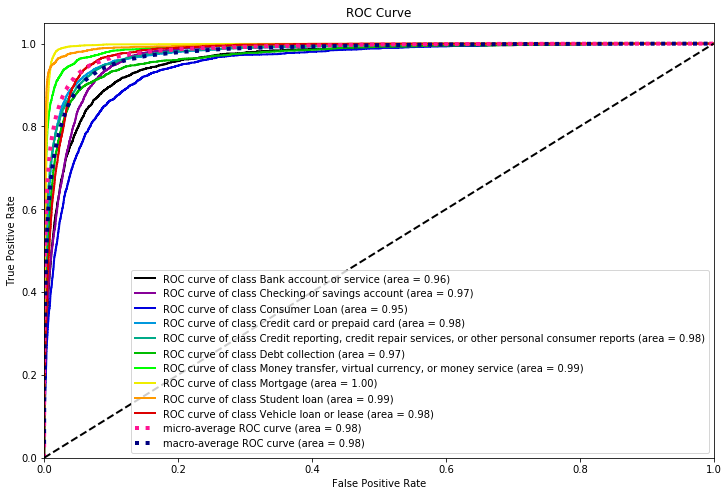

In [8]:
proba = model_logreg.predict_proba(X_test)
plot_roc_curve(y_test, proba, title="ROC Curve", figsize=(12,8))

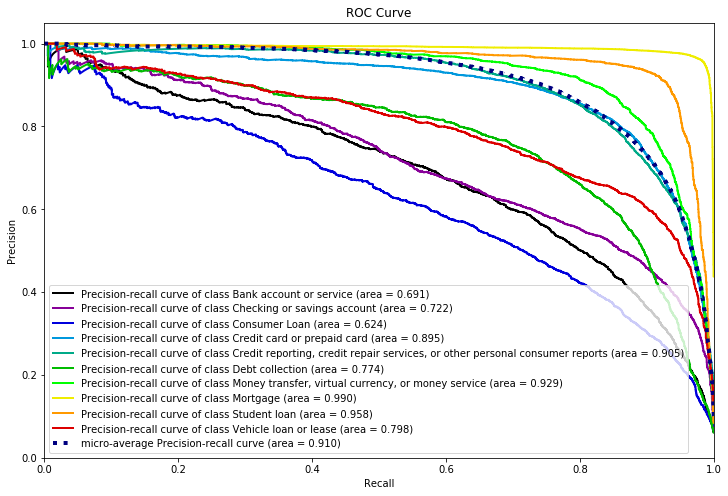

In [9]:
plot_precision_recall_curve(y_test, proba, title="ROC Curve", figsize=(12,8))

In [10]:
# This is a general purpose function to predict the class for a given text
def predict(model, text):
    if model is None:
        return 
    if text is None or text[0].strip()=="":
        return
    return model.predict(text)

# Driver code to test the function 
predict(model_logreg, ["debt collector contacted via fake process server give head debt 2011 owe claimed well fargo bank manager signed affidavit took pay loan amount 100000'debt collector contacted via fake process server give head debt 2011 owe claimed well fargo bank manager signed affidavit took pay loan amount 100000"])

array(['Debt collection'], dtype=object)